In [1]:
import sys
print(sys.executable)
import strax
import straxen
print('Straxen: ', straxen.__version__, straxen.__file__)
print('Strax: ', strax.__version__, strax.__file__)
import configparser as cp

/dali/lgrandi/strax/miniconda3/envs/strax/bin/python
Straxen:  0.7.3 /home/gvolta/XENONnT/straxen/straxen/__init__.py
Strax:  0.10.3 /dali/lgrandi/strax/strax/strax/__init__.py


In [2]:
#sys.path.append('/home/gvolta/XENONnT/gain_spe')
#from PMTanalysis import *
#PMT = PMTanalyzer('/home/gvolta/XENONnT/gain_spe/configuration.ini')

sys.path.append('/home/gvolta/XENONnT/LedAnalysis/Commissioning/led_window')
from PMTanalysis import *
PMT = PMTanalyzer('/home/gvolta/XENONnT/LedAnalysis/Commissioning/led_window/configuration_led_window.ini')





___   ___  _______ .__   __.   ______   .__   __.        .___________.   __  __             _____    _____    ____  
\  \ /  / |   ____||  \ |  |  /  __  \  |  \ |  |        |           |  |  \/  |    /\     / ____|  |_   _| /  ___| 
 \  V  /  |  |__   |   \|  | |  |  |  | |   \|  |  _   _ `---|  |----`  | \  / |   /  \    | |  __    | |   | |      
  >   <   |   __|  |  . `  | |  |  |  | |  . `  | | \ | |    |  |       | |\/| |  / /\ \   | | |_ |   | |   | |      
 /  .  \  |  |____ |  |\   | |  `--`  | |  |\   | |  \| |    |  |       | |  | | / ____ \  | |__| |  _| |_  | |___  
/__/ \__\ |_______||__| \__|  \______/  |__| \__| |_|\__|    |__|       |_|  |_|/_/    \_\ \ _____| |_____| \_____|  
powered by Giovanni Volta, Chiara Capelli and Shingo Kazama (c)




Configuration file:  /home/gvolta/XENONnT/LedAnalysis/Commissioning/led_window/configuration_led_window.ini


In [3]:
strax.Mailbox.DEFAULT_MAX_MESSAGES = 2
st = straxen.contexts.xenonnt_online()
st = st.new_context(storage=[strax.DataDirectory(PMT.straxdata, provide_run_metadata=False)])

In [ ]:
!ls /dali/lgrandi/xenonnt/raw/*7333*

In [4]:
data_rr_ = st.get_array('007333', 'raw_records', max_workers=20, seconds_range=(0, 1))

In [5]:
data_rr  = PMT.get_signal(data_rr_)

In [6]:
amplitude = PMT.get_amplitude(data_rr, window=[0,160])

In [ ]:
pmt = 10

fig = plt.figure(figsize=(15, 6))
ADC = np.arange(-10, 500, 1)
plt.hist(amplitude[amplitude['channel']==pmt]['amplitude'], bins=ADC)
plt.yscale('log')
plt.grid(color='grey', linestyle='-', linewidth=2, alpha=0.25)
plt.xlim(0,200)

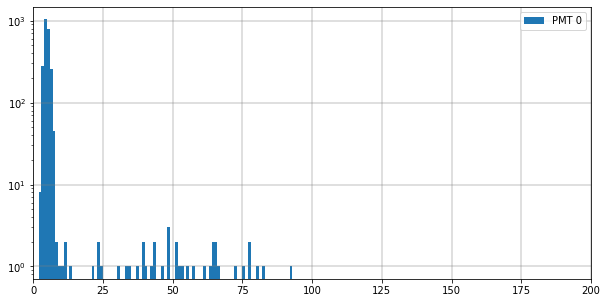

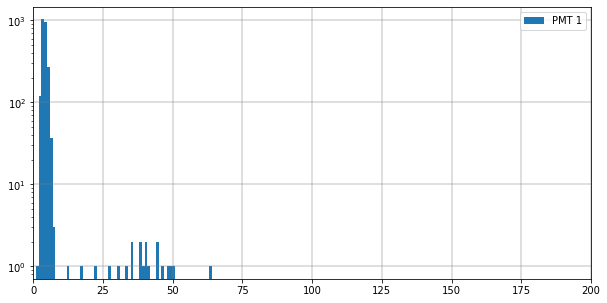

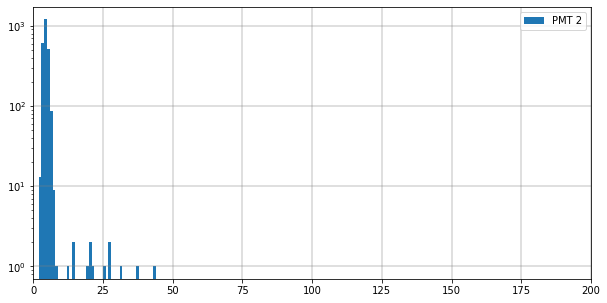

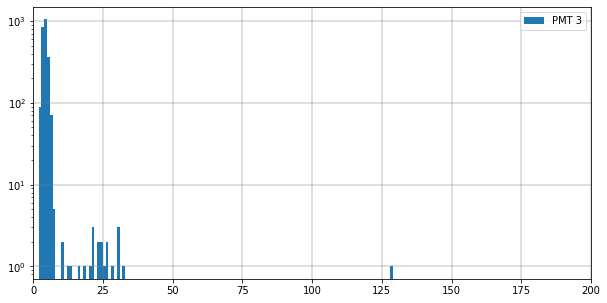

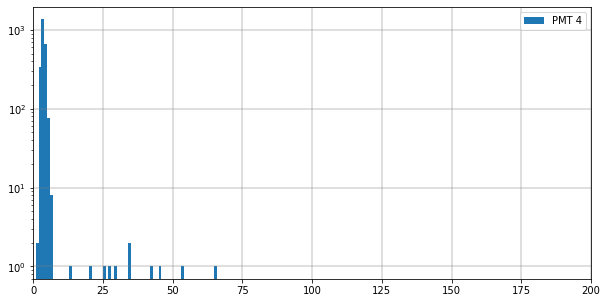

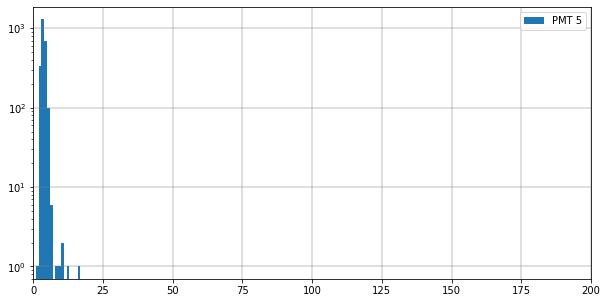

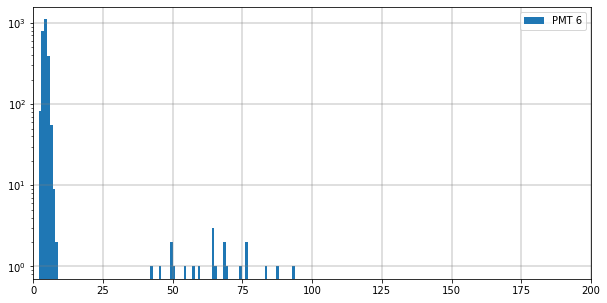

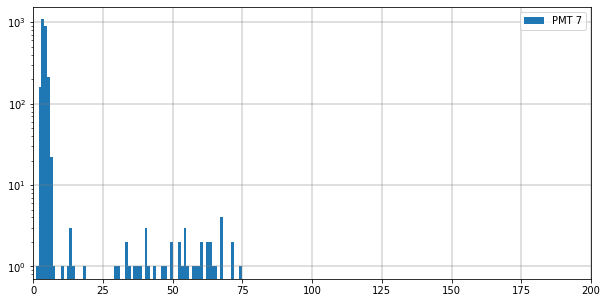

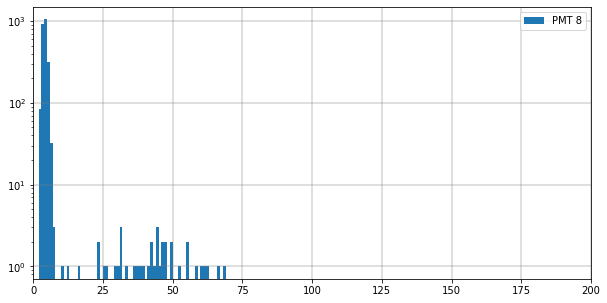

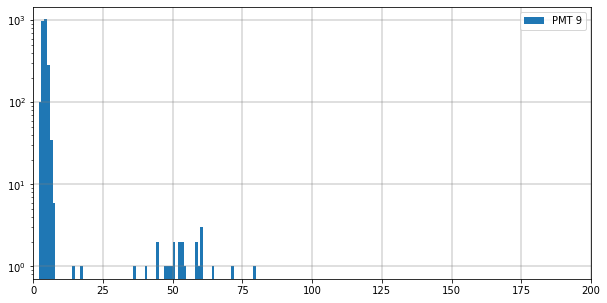

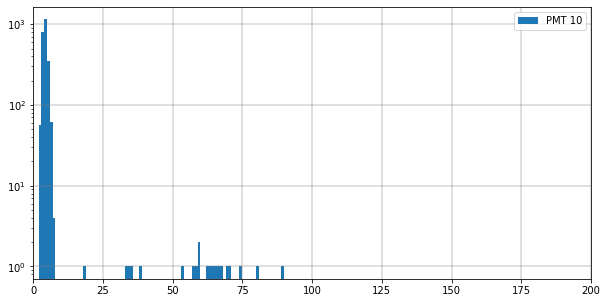

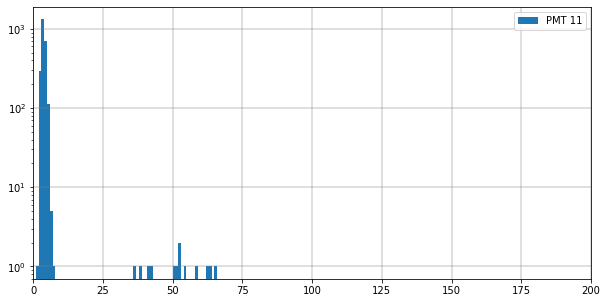

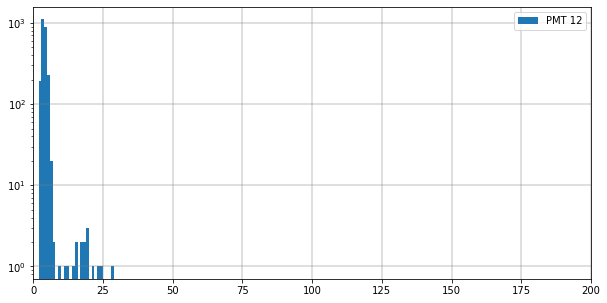

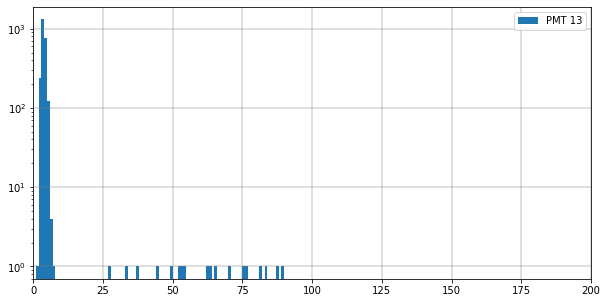

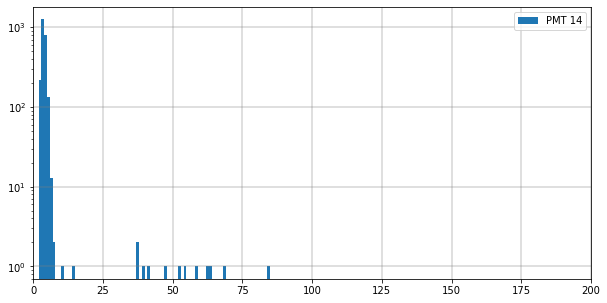

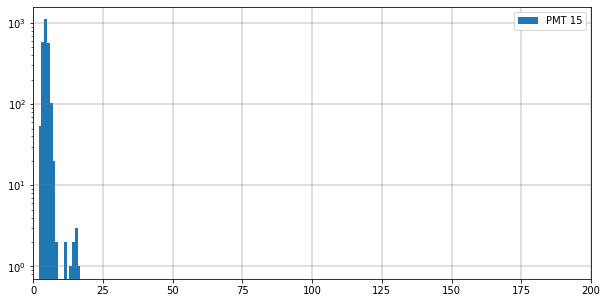

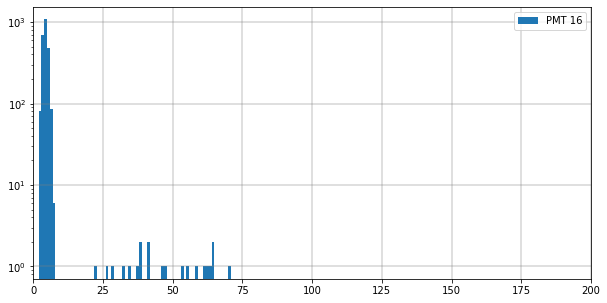

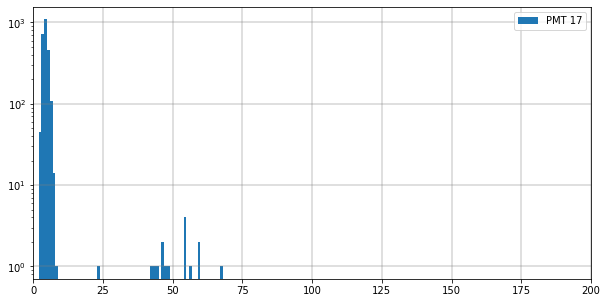

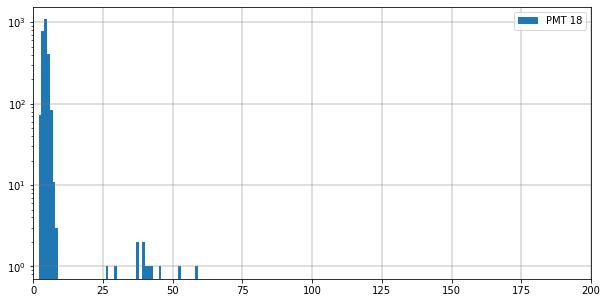

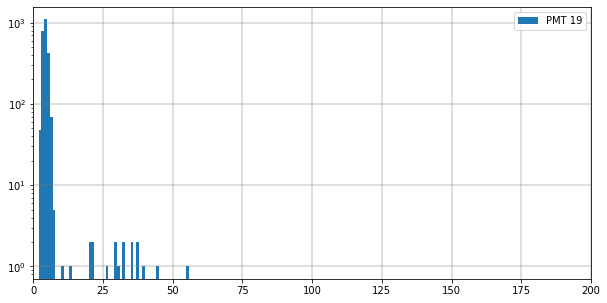

In [7]:
channels = np.arange(0, 494, 1)
for ch in range(20):
    fig = plt.figure(figsize=(10, 5))
    ADC = np.arange(-10, 500, 1)
    plt.hist(amplitude[amplitude['channel']==ch]['amplitude'], bins=ADC, label='PMT %s'%(str(ch)))
    plt.yscale('log')
    plt.grid(color='grey', linestyle='-', linewidth=2, alpha=0.25)
    plt.xlim(0,200)
    plt.legend(loc=0)
    plt.show()

In [ ]:
fig = plt.figure(figsize=(15, 6))
ax = fig.gca(projection='3d')
ax.view_init(elev=20., azim=-35)

for i in range(500, 800):
    event = i
    time = np.arange(0,160, 1)
    ADC = data_rr[data_rr['channel']==pmt]['data'][event][:160]
    y = event*np.ones((160,), dtype=int)
    plt.plot(time, y, ADC)
    ax.set_xlim3d(0, 160)
    #ax.set_ylim3d(0,10)
    ax.set_zlim3d(-20,100)

plt.legend()
plt.tight_layout()
plt.show()

### SPE input:
In order to fid the LED window we have to put our attention into the SPE events. Then, the amplitude spectrum is analyzed in order to look if the SPE events are present and to find the fit input.
It is not straigh forward to find the input, do you have any suggestion?

In [ ]:
ch = 10
fit_input, binning, check = PMT.get_speinput(amplitude=amplitude, channel=ch)

plt.figure(figsize=(20,10))
H, B, _  = plt.hist(amplitude[amplitude['channel']==ch]['amplitude'], 
                    bins=binning,
                    label='SPE: %s'%(str(check)))
plt.plot(B[fit_input], H[fit_input], '*')

plt.yscale('log')
#plt.ylim(1e0)
plt.show()

In [ ]:
channels = np.arange(0, 494, 1)
good_ch = [ ]
bad_ch = [ ]
for ch in channels:
    print(ch)
    try:
        gauss, result_fit, fit_interval = PMT.get_sperough(amplitude=amplitude, channel=ch)
        def gaussian(x,*p) :
            # A gaussian peak with:
            #   Peak height above background : p[0]
            #   Central value                : p[1]
            #   Standard deviation           : p[2]
            return p[0]*np.exp(-1*(x-p[1])**2/(2*p[2]**2))

        plt.figure(figsize=(10,5))
        H, B, _  = plt.hist(amplitude[amplitude['channel']==ch]['amplitude'], 
                            bins=binning, label='PMT %s'%(str(ch)))

        plt.plot(B[fit_input], H[fit_input], '*')
        result_fit.plot_fit(show_init=True)

        popt  = result_fit.best_values
        N     = popt['g_amplitude']/(np.sqrt(2*np.pi)*popt['g_sigma'])
        mu    = popt['g_center']
        sigma = popt['g_sigma']

        x = np.linspace(0,100, 100)
        y = gaussian(x, N, mu, sigma)
        plt.plot(x, y, 'k--')

        plt.yscale('log')
        plt.ylim(1e-1)
        plt.show()
    except:
        bad_ch.append(ch)
    

### LED window
All the amplitude spectrum are fitted by a gaussian from which is defined the mean of SPE. Thene, the window is defined as the median $\pm$ sigma of the SPE sample.

In [ ]:
good_ch = [ ]
for ch in channels:
    if ch not in bad_ch:
        good_ch.append(ch)

In [ ]:
df_fit, df_led, window = PMT.get_ledwindow(amplitude , good_ch)

In [ ]:
PMT.ledwindowplot(data=df_led, lastchannel=494)

In [ ]:
print(np.nanmedian(df_led['idx_led']))
print(np.nanstd(df_led['idx_led']))
print(np.nanmedian(df_led['idx_led']) - np.nanstd(df_led['idx_led']) , 
      np.nanmedian(df_led['idx_led']) + np.nanstd(df_led['idx_led']))

In [ ]:
median = np.nanmedian(df_led['idx_led'])
std = np.nanstd(df_led['idx_led'])
window = [int(median-2*std),int(median+2*std)] 

fig = plt.figure(figsize=(22,10))
plt.subplot(121)
plt.hist2d(df_led['channel'], df_led['idx_led'], bins=(494,160), 
           range=((0,494),(0,160)), cmap=plt.cm.plasma, norm=mpl.colors.LogNorm(), cmin = 1,alpha = 1)
plt.colorbar(label='Number of events')
plt.hlines(y=window[0], xmin=0, xmax=494)
plt.hlines(y=window[1], xmin=0, xmax=494)
plt.xlabel('PMT', fontsize=14)
plt.ylabel('Sample [10ns]', fontsize=14)
plt.tick_params(labelsize=20)

plt.subplot(122)
plt.hist(df_led['idx_led'], bins=160, range=(0,160), histtype='step', color='black')
plt.xlim(0,160)
plt.axvspan(*window, color='grey', alpha=0.2)
plt.title('LED window: '+str(median-2*std)+' - '+str(median+2*std))
plt.xlabel('Number of events', fontsize=14)
plt.ylabel('Sample [10ns]', fontsize=14)
plt.tick_params(labelsize=20)

In [ ]:
fig = plt.figure(figsize=(15, 6))

event = 13
time = np.arange(0,160, 1)
ADC = data_rr[data_rr['channel']==pmt]['data'][event][:160]
plt.plot(time, ADC)
plt.axvspan(*window, color='yellow', alpha=0.2)
plt.xlim(0, 160)
plt.ylim(-20,100)

plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
data_rr_['data'][0]

In [ ]:
st.data_info('raw_records')

In [ ]:
ch = 1
PMT = data_rr_[data_rr_['channel']==ch]
for i in range(30):
    plt.figure(figsize=(20,6))
    event = i
    wf = PMT['data'][i][:]
    bsl = np.sum(wf[0:40])/(40.-0.)
    plt.plot(-1.*(wf-bsl))
    #plt.xlim(0,200)
    plt.ylim(-20, 150)
    plt.xlabel('sample [10 ns]', fontsize=18)
    plt.tick_params(labelsize=15) 
    plt.show()

In [ ]:
for ch in range(494):
    PMT = data_rr_[data_rr_['channel']==ch]
    try:
        plt.figure(figsize=(10,4))
        wf = PMT['data'][0][:201]
        bsl = np.sum(wf[0:40])/(40.-0.)
        x = np.arange(0,101, 1)
        plt.plot(x, -1.*(wf-bsl), label='PMT '+str(ch))
        plt.legend(loc='upper right', frameon=False)
        plt.xlim(0,100)
        plt.ylim(-20, 150)
        plt.xlabel('sample [10 ns]', fontsize=18)
        plt.ylabel('ADC', fontsize=18)
        plt.tick_params(labelsize=15) 
        plt.show()
    except:
        print('Problema in PMT '+str(ch))

In [ ]:
ch = 0
PMT = data_rr_[data_rr_['channel']==ch]
datatype = [('baseline', np.float32), ('data', object)]
wf = np.zeros(int(len(PMT)/3), dtype=datatype)

for i in range(len(wf)):
    wf_0 = PMT['data'][int(i*3)+0]
    wf_1 = PMT['data'][int(i*3)+1]
    wf_2 = PMT['data'][int(i*3)+2]
    mask = wf_2>0
    wf_ = np.concatenate((wf_0, wf_1, wf_2[mask]))
    wf['baseline'][i] = np.sum(wf_[0:100])/(100.-0.)
    wf['data'][i]     = wf_

In [ ]:
 for i in range(100):
    plt.figure(figsize=(20,6))
    event = i
    plt.plot(-1.*(wf['data'][event]-wf['baseline'][event]))
    plt.xlim(0,400)
    plt.ylim(-10, 50)
    plt.xlabel('sample [10 ns]', fontsize=18)
    plt.tick_params(labelsize=15) 
    plt.show()

In [ ]:
path_plot_commissioning = Config.get('plots_pars', 'path_plot_commissioning') + str(PMT.date) + '/'
for ch in channels:
    print(ch)
    try:
        fig = plt.figure(figsize=(10, 5))
        ADC = np.arange(-10, 500, 1)
        plt.hist(amplitude[amplitude['channel']==ch]['amplitude'], bins=ADC, label='PMT %s'%(str(ch)))
        plt.yscale('log')
        plt.grid(color='grey', linestyle='-', linewidth=2, alpha=0.25)
        plt.xlim(0,200)
        plt.legend(loc=0)
        print('Salvo lo spettro di '+str(ch)+' qui: '+path_plot_commissioning+'AmpSpec/run'+run+'_PMT'+str(ch)+'.png')
        plt.savefig(path_plot_commissioning+'AmpSpec/run'+run+'_PMT'+str(ch)+'.png')
        plt.close(fig)
    except:
        print('Something went wrong in PMT')

In [ ]:
## SPE rough spectrum fit
              bad_ch = [ ]
for ch in range(50):
    print(ch)
    try:
        gauss, result_fit, fit_interval = PMT.get_sperough(amplitude=amplitude, channel=ch)
        def gaussian(x,*p) :
            # A gaussian peak with:
            #   Peak height above background : p[0]
            #   Central value                : p[1]
            #   Standard deviation           : p[2]
            return p[0]*np.exp(-1*(x-p[1])**2/(2*p[2]**2))

        plt.figure(figsize=(10,5))
        H, B, _  = plt.hist(amplitude[amplitude['channel']==ch]['amplitude'], 
                            bins=binning, label='PMT %s'%(str(ch)))

        plt.plot(B[fit_input], H[fit_input], '*')
        result_fit.plot_fit(show_init=True)

        popt  = result_fit.best_values
        N     = popt['g_amplitude']/(np.sqrt(2*np.pi)*popt['g_sigma'])
        mu    = popt['g_center']
        sigma = popt['g_sigma']

        x = np.linspace(0,100, 100)
        y = gaussian(x, N, mu, sigma)
        plt.plot(x, y, 'k--')

        plt.yscale('log')
        plt.ylim(1e-1)
        print('Salvo il fit di '+str(ch)+' qui: '+path_plot_commissioning+'SPEfit/run'+run+'_PMT'+str(ch)+'.png')
        plt.savefig(path_plot_commissioning+'SPEfit/run'+run+'_PMT'+str(ch)+'.png')
        plt.close(fig)
    except:
        bad_ch.append(ch)
        print('BAD')
        
### Good channel
good_ch = [ ]
for ch in channels:
    if ch not in bad_ch:
        good_ch.append(ch)
print(good_ch)

### LED window
try:
    df_fit, df_led, window = PMT.get_ledwindow(amplitude , good_ch)
    print(window)
    path_to_save_date = Config.get('output_pars','path_plot_commissioning') + str(PMT.date) + '/'
    name = 'LED_window_run'+run
    np.savez(path_to_save_date+name, x=df_fit, y=df_led)
except:
    print('Somethin went wrong in PMT')